In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load Data
train_data = pd.read_csv('optdigits.tra', header=None)
test_data = pd.read_csv('optdigits.tes', header=None)

# 分离特征和目标
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [3]:
# Step 2: Preprocess Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_nmf = MinMaxScaler()
X_train_nmf = scaler_nmf.fit_transform(X_train)
X_test_nmf = scaler_nmf.transform(X_test)

In [4]:
# Step 3: Apply Decomposition Techniques
def apply_decomposition(X, method, n_components=10):
    if method == 'PCA':
        model = PCA(n_components=n_components)
    elif method == 'FastICA':
        model = FastICA(n_components=n_components, random_state=42)
    elif method == 'NMF':
        model = NMF(n_components=n_components, max_iter=1000, random_state=42, init='random')
    transformed_data = model.fit_transform(X)
    return model, transformed_data

# Apply decomposition
n_components = 10
pca_model, X_train_pca = apply_decomposition(X_train_scaled, 'PCA', n_components)
X_test_pca = pca_model.transform(X_test_scaled)

ica_model, X_train_ica = apply_decomposition(X_train_scaled, 'FastICA', n_components)
X_test_ica = ica_model.transform(X_test_scaled)

nmf_model, X_train_nmf_transformed = apply_decomposition(X_train_nmf, 'NMF', n_components)
X_test_nmf_transformed = nmf_model.transform(X_test_nmf)

# 增加降维维度（更高的 PCA 维度）
n_components = 30
pca_model_high, X_train_pca_high = apply_decomposition(X_train_scaled, 'PCA', n_components)
X_test_pca_high = pca_model_high.transform(X_test_scaled)

# 使用 LDA 降维
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=9)  # LDA 的维度为类别数 - 1
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

In [5]:
# Step 4: Train and Evaluate Models
def train_and_evaluate(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1_score': f1_score(y_test, y_pred, average='macro')
    }
    print(classification_report(y_test, y_pred, zero_division=0))
    return metrics

metrics_original = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test)
metrics_pca = train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test)
metrics_ica = train_and_evaluate(X_train_ica, y_train, X_test_ica, y_test)
metrics_nmf = train_and_evaluate(X_train_nmf_transformed, y_train, X_test_nmf_transformed, y_test)

# 分类器评估更高维度的 PCA 和 LDA
metrics_pca_high = train_and_evaluate(X_train_pca_high, y_train, X_test_pca_high, y_test)
metrics_lda = train_and_evaluate(X_train_lda, y_train, X_test_lda, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.95      0.99      0.97       182
           2       0.99      0.99      0.99       177
           3       0.97      0.96      0.97       183
           4       0.98      0.98      0.98       181
           5       0.97      0.98      0.97       182
           6       0.99      0.97      0.98       181
           7       0.99      0.93      0.96       179
           8       0.94      0.94      0.94       174
           9       0.91      0.93      0.92       180

    accuracy                           0.97      1797
   macro avg       0.97      0.97      0.97      1797
weighted avg       0.97      0.97      0.97      1797

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       178
           1       0.88      0.97      0.92       182
           2       0.98      0.93      0.95       177
           3       0.88 

           Method  Accuracy  Precision   Recall  F1-Score
         Original  0.967168   0.967548 0.967068  0.967141
    PCA (10 dims)  0.920979   0.921234 0.920640  0.920180
FastICA (10 dims)  0.904841   0.905158 0.904528  0.904407
    NMF (10 dims)  0.920979   0.922857 0.920831  0.921286
    PCA (30 dims)  0.959933   0.960643 0.959747  0.959886
     LDA (9 dims)  0.944352   0.945705 0.944117  0.944389


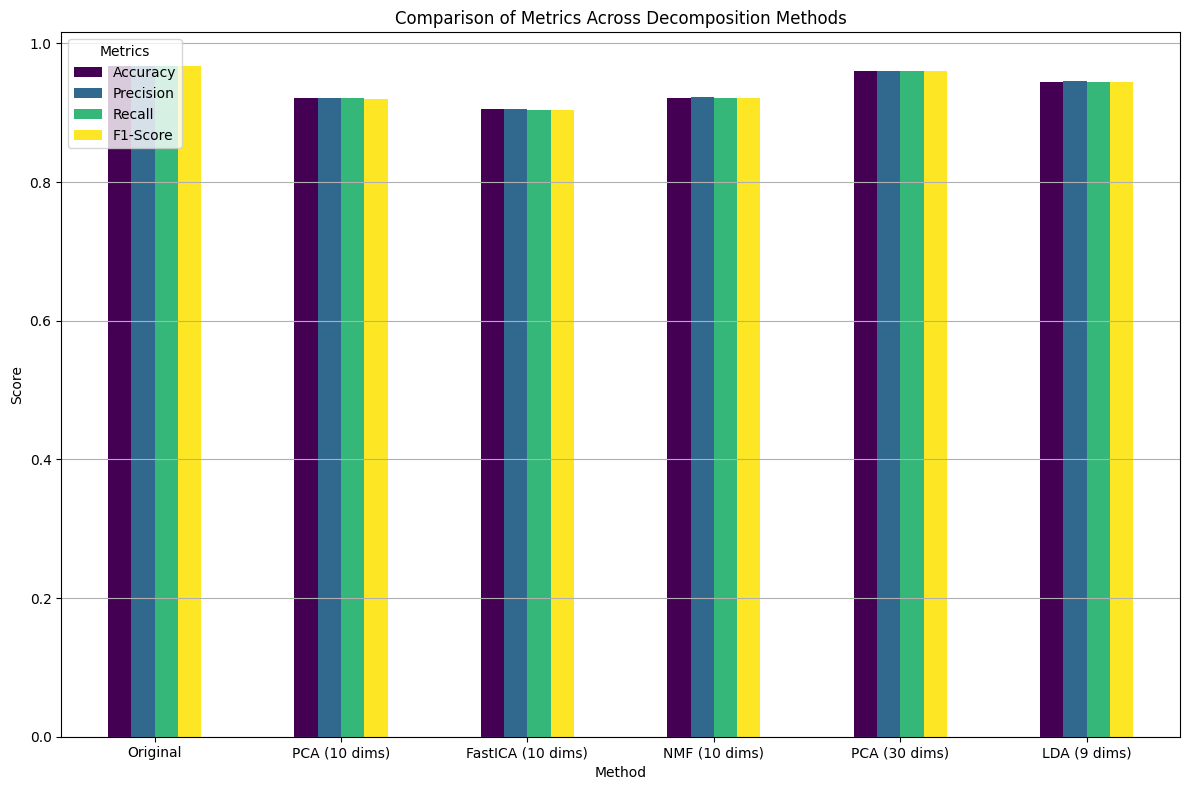

In [6]:
# Visualize results
# 构建性能表格和柱状图的数据
metrics_table = pd.DataFrame({
    'Method': [
        'Original', 
        'PCA (10 dims)', 
        'FastICA (10 dims)', 
        'NMF (10 dims)', 
        'PCA (30 dims)', 
        'LDA (9 dims)'
    ],
    'Accuracy': [
        metrics_original['accuracy'], 
        metrics_pca['accuracy'], 
        metrics_ica['accuracy'], 
        metrics_nmf['accuracy'], 
        metrics_pca_high['accuracy'], 
        metrics_lda['accuracy']
    ],
    'Precision': [
        metrics_original['precision'], 
        metrics_pca['precision'], 
        metrics_ica['precision'], 
        metrics_nmf['precision'], 
        metrics_pca_high['precision'], 
        metrics_lda['precision']
    ],
    'Recall': [
        metrics_original['recall'], 
        metrics_pca['recall'], 
        metrics_ica['recall'], 
        metrics_nmf['recall'], 
        metrics_pca_high['recall'], 
        metrics_lda['recall']
    ],
    'F1-Score': [
        metrics_original['f1_score'], 
        metrics_pca['f1_score'], 
        metrics_ica['f1_score'], 
        metrics_nmf['f1_score'], 
        metrics_pca_high['f1_score'], 
        metrics_lda['f1_score']
    ]
})

# 打印表格
print(metrics_table.to_string(index=False))

# 绘制柱状图
metrics_table.set_index('Method').plot(kind='bar', figsize=(12, 8), colormap='viridis', rot=0)
plt.title('Comparison of Metrics Across Decomposition Methods')
plt.ylabel('Score')
plt.xlabel('Method')
plt.legend(loc='upper left', title="Metrics")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
